# 5. Category prediction with Ensemble Modelling

In [1]:
import time
import pickle
import collections
import string
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
cwd = Path('.')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (50,30)
plt.rcParams.update({'font.size': 22})
import pandas as pd
import tensorflow as tf
import nltk

In [3]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedShuffleSplit

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [4]:
from random import seed
RANDOM = 42
seed(RANDOM)
np.random.seed(RANDOM)

The preprocessing for predicting with title and tags is different from the preprocessing for predicting with comments

Special care must be taken when we combine the preprocessed data

In [5]:
# Load the processed data from the previous 2 notebooks
concat_df = pd.read_csv(cwd/'output'/"concat_comment_videos_df.csv")
videos_df = pd.read_csv(cwd/'output'/"title_tags_videos_df.csv")

In [4]:
concat_df = concat_df[['video_id', 'comment_text']]

In [5]:
videos_df = videos_df[['video_id', 'title_and_tags', 'category_id', 'category_name']]

In [6]:
concat_df.head()

,video_id,comment_text
0,--JinobXWPk,saw wandering spider bathroom seriously never ...
1,--y69Ui8xwM,favourite amazing goals let know comments post...
2,-1fzGnFwz9M,make interesting cartoons need help go channel...
3,-2hRYEFiPSA,one thing upset chester death way media talked...
4,-3AGlBYyLjo,interviews gary chandling god tom passed away ...


In [7]:
videos_df.head()

,video_id,title_and_tags,category_id,category_name
0,XpVt6Z1Gjjo,year vlogging logan paul changed youtube forev...,9,Entertainment
1,K4wEI5zhHB0,iphone x introducing iphone x apple apple ipho...,13,Science & Technology
2,cLdxuaxaQwc,response none,7,People & Blogs
3,WYYvHb03Eog,apple iphone x first look apple iphone x hands...,13,Science & Technology
4,sjlHnJvXdQs,iphone x parody jacksfilms parody parodies iph...,8,Comedy


In [8]:
df = pd.merge(videos_df, concat_df, on='video_id', how='inner')

In [9]:
df.head()

,video_id,title_and_tags,category_id,category_name,comment_text
0,XpVt6Z1Gjjo,year vlogging logan paul changed youtube forev...,9,Entertainment,logan paul yo big day following start vine cha...
1,cLdxuaxaQwc,response none,7,People & Blogs,love pewdiepie apologize fine seeing much idio...
2,WYYvHb03Eog,apple iphone x first look apple iphone x hands...,13,Science & Technology,wan na unlock phone bed dark girls unlock ipho...
3,WYYvHb03Eog,apple iphone x first look iphone x iphone x ha...,13,Science & Technology,wan na unlock phone bed dark girls unlock ipho...
4,sjlHnJvXdQs,iphone x parody jacksfilms parody parodies iph...,8,Comedy,nothing scarier guy replying every comment adv...


In [10]:
df = df.drop_duplicates(subset='video_id')

In [11]:
df.duplicated(subset='video_id').sum()

0

In [12]:
df.duplicated(subset='title_and_tags').sum()

0

In [13]:
df.duplicated(subset='comment_text').sum()

0

In [14]:
len(df)

3142

In [15]:
df = df.dropna()

In [16]:
df.head()

,video_id,title_and_tags,category_id,category_name,comment_text
0,XpVt6Z1Gjjo,year vlogging logan paul changed youtube forev...,9,Entertainment,logan paul yo big day following start vine cha...
1,cLdxuaxaQwc,response none,7,People & Blogs,love pewdiepie apologize fine seeing much idio...
2,WYYvHb03Eog,apple iphone x first look apple iphone x hands...,13,Science & Technology,wan na unlock phone bed dark girls unlock ipho...
4,sjlHnJvXdQs,iphone x parody jacksfilms parody parodies iph...,8,Comedy,nothing scarier guy replying every comment adv...
5,cMKX2tE5Luk,disaster artist official trailer hd films trai...,0,Film & Animation,sure speak everyone say wait tearing apart htt...


Initialize these tuned models (No NN for now)
- We have 11 models, thus we can take a majority voting.

### COMMENT MODELS:
- KNeighborsClassifier - Best: 0.590461 using {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'distance'}
- RandomForestClassifier - Best: 0.495707 using {'n_estimators': 88, 'random_state': 42}
- LogisticRegression - Best: 0.658824 using {'C': 35, 'penalty': 'l2', 'random_state': 42}
- SVC - Best: 0.645151 using {'C': 21, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 42}
- MultinomialNB - Best: 0.554849 using {'alpha': 0.0, 'fit_prior': False}

### TITLE_AND_TAGS MODELS:
- KNeighborsClassifier - Best: 0.649941 using {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'distance'}
- DecisionTreeClassifier - Best: 0.603601 using {'random_state': 42}
- RandomForestClassifier - Best: 0.688312 using {'n_estimators': 87, 'random_state': 42}
- LogisticRegression - Best: 0.703365 using {'C': 50, 'penalty': 'l2', 'random_state': 42}
- SVC - Best: 0.693329 using {'C': 11.1, 'gamma': 0.09, 'kernel': 'rbf', 'random_state': 42}
- MultinomialNB - Best: 0.709563 using {'alpha': 0.12, 'fit_prior': False}

In [18]:
comment_models = [
    KNeighborsClassifier(algorithm='auto', n_neighbors=20, weights='distance'),
    #RandomForestClassifier(n_estimators=88, random_state=42),
    LogisticRegression(C=35, penalty='l2', random_state=42),
    SVC(C=21, gamma=0.1, kernel='rbf', random_state=42),
    #MultinomialNB(alpha=0.0, fit_prior=False)
]
title_and_tags_models = [
    KNeighborsClassifier(algorithm='auto', n_neighbors=6, weights='distance'),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=87, random_state=42),
    LogisticRegression(C=50, penalty='l2', random_state=42),
    SVC(C=11.1, gamma=0.09, kernel='rbf', random_state=42),
    MultinomialNB(alpha=0.12, fit_prior=False)
]

In [19]:
vectorizer = TfidfVectorizer()
comment_text_X = vectorizer.fit_transform(df['comment_text'].values)
title_and_tags_X = vectorizer.fit_transform(df['title_and_tags'].values)
y = df['category_id'].to_numpy()

In [20]:
comment_text_X.shape

(3141, 162491)

In [21]:
title_and_tags_X.shape

(3141, 15977)

In [22]:
y.shape

(3141,)

In [23]:
def get_final_pred(output_of_models):
    pred_length = output_of_models[0].shape[0]
    result = []
    for i in range(pred_length):
        sample_preds = np.array([output[i] for output in output_of_models])
        result.append(np.argmax(np.bincount(sample_preds)))
    return np.array(result)        

In [24]:
# full ensemble (11 models): 0.7360110615352895
# remove models with < 59% orginal acc (9 models): 0.7379404129504286
# remove models with < 64% orginal acc (7 models): 0.7255349482207074

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
split_accuracies = []
# Can use title_and_tags_X as well for skf.split, doesnt matter. We just want the indices
split = 0
for train_index, test_index in skf.split(comment_text_X, y):
    split += 1
    output_of_models = []
    comment_text_X_train, comment_text_X_test = comment_text_X[train_index], comment_text_X[test_index]
    title_and_tags_X_train, title_and_tags_X_test = title_and_tags_X[train_index], title_and_tags_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for comment_model in comment_models:
        comment_model.fit(comment_text_X_train, y_train)
        y_pred = comment_model.predict(comment_text_X_test)
        output_of_models.append(y_pred)
        
    for title_and_tags_model in title_and_tags_models:
        title_and_tags_model.fit(title_and_tags_X_train, y_train)
        y_pred = title_and_tags_model.predict(title_and_tags_X_test)
        output_of_models.append(y_pred)
        
    final_pred = get_final_pred(output_of_models)
    split_accuracies.append(accuracy_score(y_test, final_pred))
    print(f"Done split {split}")
print(f"Ensemble model's 5 fold stratified CV score is: {sum(split_accuracies)/len(split_accuracies)}")

Done split 1
Done split 2
Done split 3
Done split 4
Done split 5
Ensemble model's 5 fold stratified CV score is: 0.7379404129504286


Okay now we know best ensemble is with top 9 models - 0.7379404129504286

#### Plot confusion matrix for ensemble

In [46]:
# Note we cant use train_test_split, cos we need the indices now, not just the samples
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM)
output_of_models = []
for train_index, test_index in sss.split(comment_text_X, y): # this will only run once
    comment_text_X_train, comment_text_X_test = comment_text_X[train_index], comment_text_X[test_index]
    title_and_tags_X_train, title_and_tags_X_test = title_and_tags_X[train_index], title_and_tags_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for comment_model in comment_models:
        comment_model.fit(comment_text_X_train, y_train)
        y_pred = comment_model.predict(comment_text_X_test)
        output_of_models.append(y_pred)
        
    for title_and_tags_model in title_and_tags_models:
        title_and_tags_model.fit(title_and_tags_X_train, y_train)
        y_pred = title_and_tags_model.predict(title_and_tags_X_test)
        output_of_models.append(y_pred)
        
    y_pred = get_final_pred(output_of_models)

In [47]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          type_of_plot,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if type_of_plot == 'precision':
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
        print("Precision confusion matrix")
    if type_of_plot == 'recall':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif type_of_plot == "no_normalization":
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if type_of_plot != "no_normalization" else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

In [48]:
# Get category id to name mapping
category_id_to_word = {}
for _, row in df.iterrows():
    if row['category_id'] not in category_id_to_word:
        category_id_to_word[row['category_id']] = row['category_name']

In [49]:
sorted(list(category_id_to_word.items()), key=lambda x: x[0])

[(0, 'Film & Animation'),
 (1, 'Autos & Vehicles'),
 (2, 'Music'),
 (3, 'Pets & Animals'),
 (4, 'Sports'),
 (5, 'Travel & Events'),
 (6, 'Gaming'),
 (7, 'People & Blogs'),
 (8, 'Comedy'),
 (9, 'Entertainment'),
 (10, 'News & Politics'),
 (11, 'Howto & Style'),
 (12, 'Education'),
 (13, 'Science & Technology')]

Confusion matrix, without normalization
Precision confusion matrix


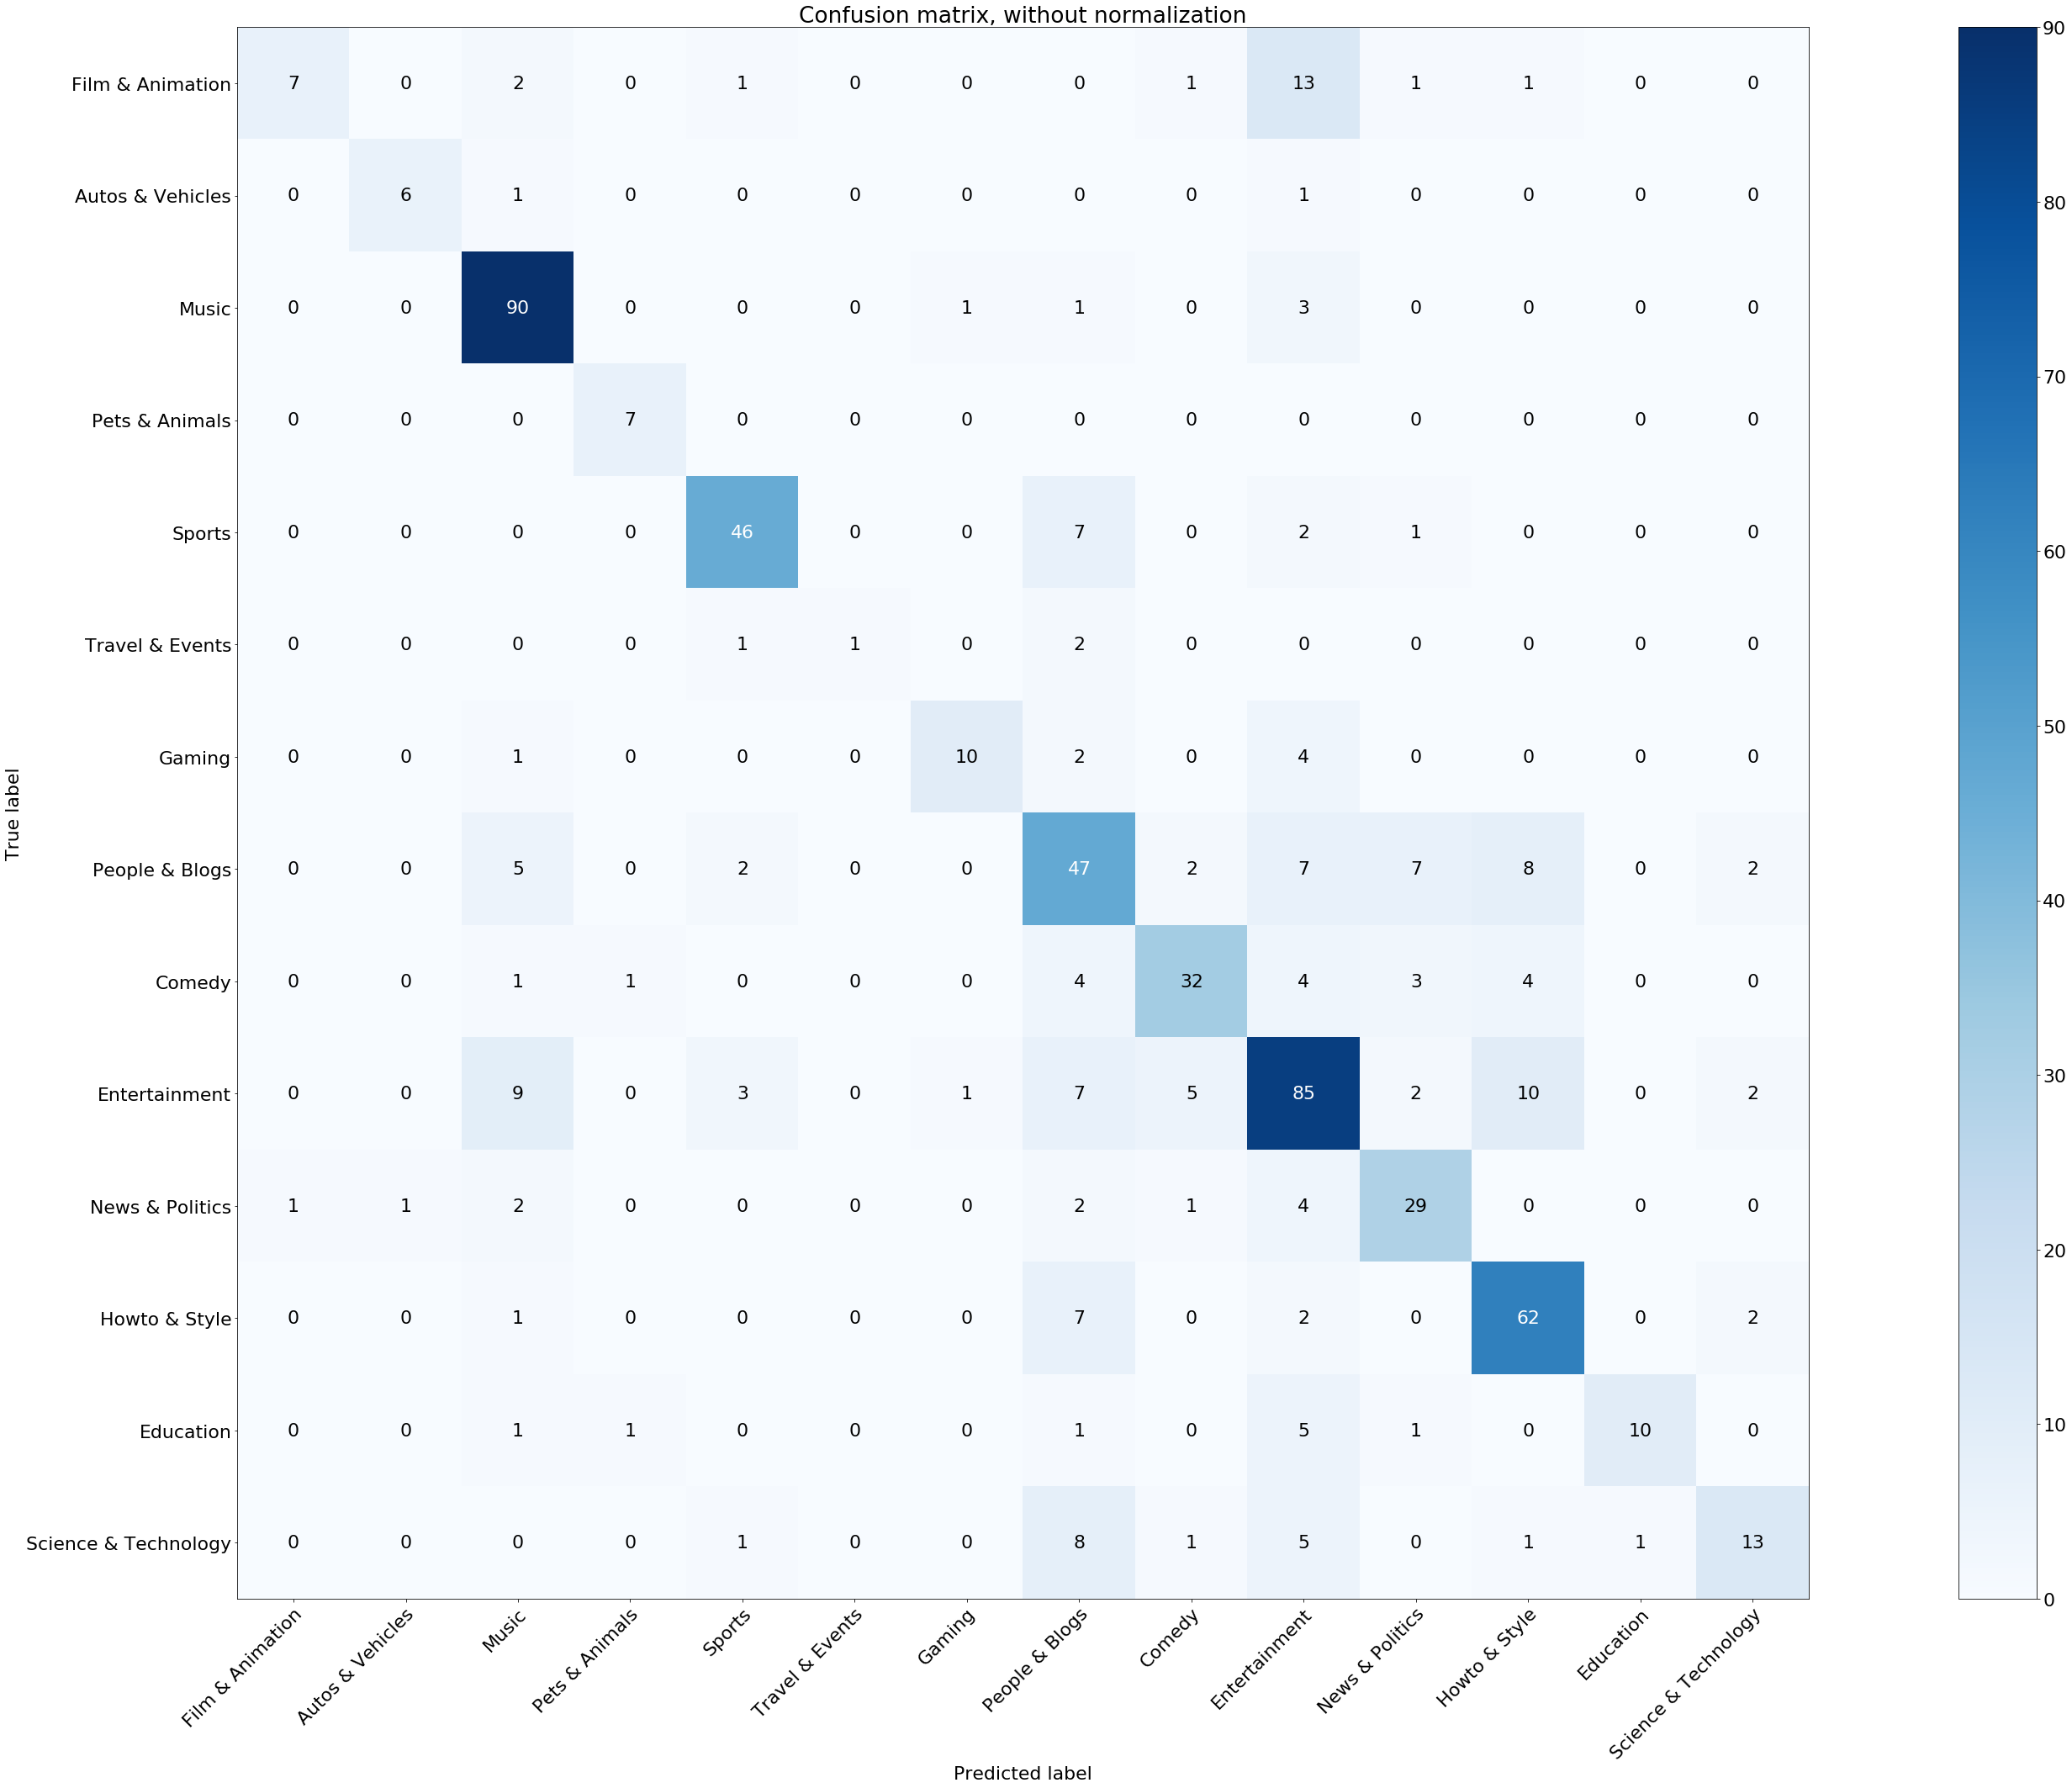

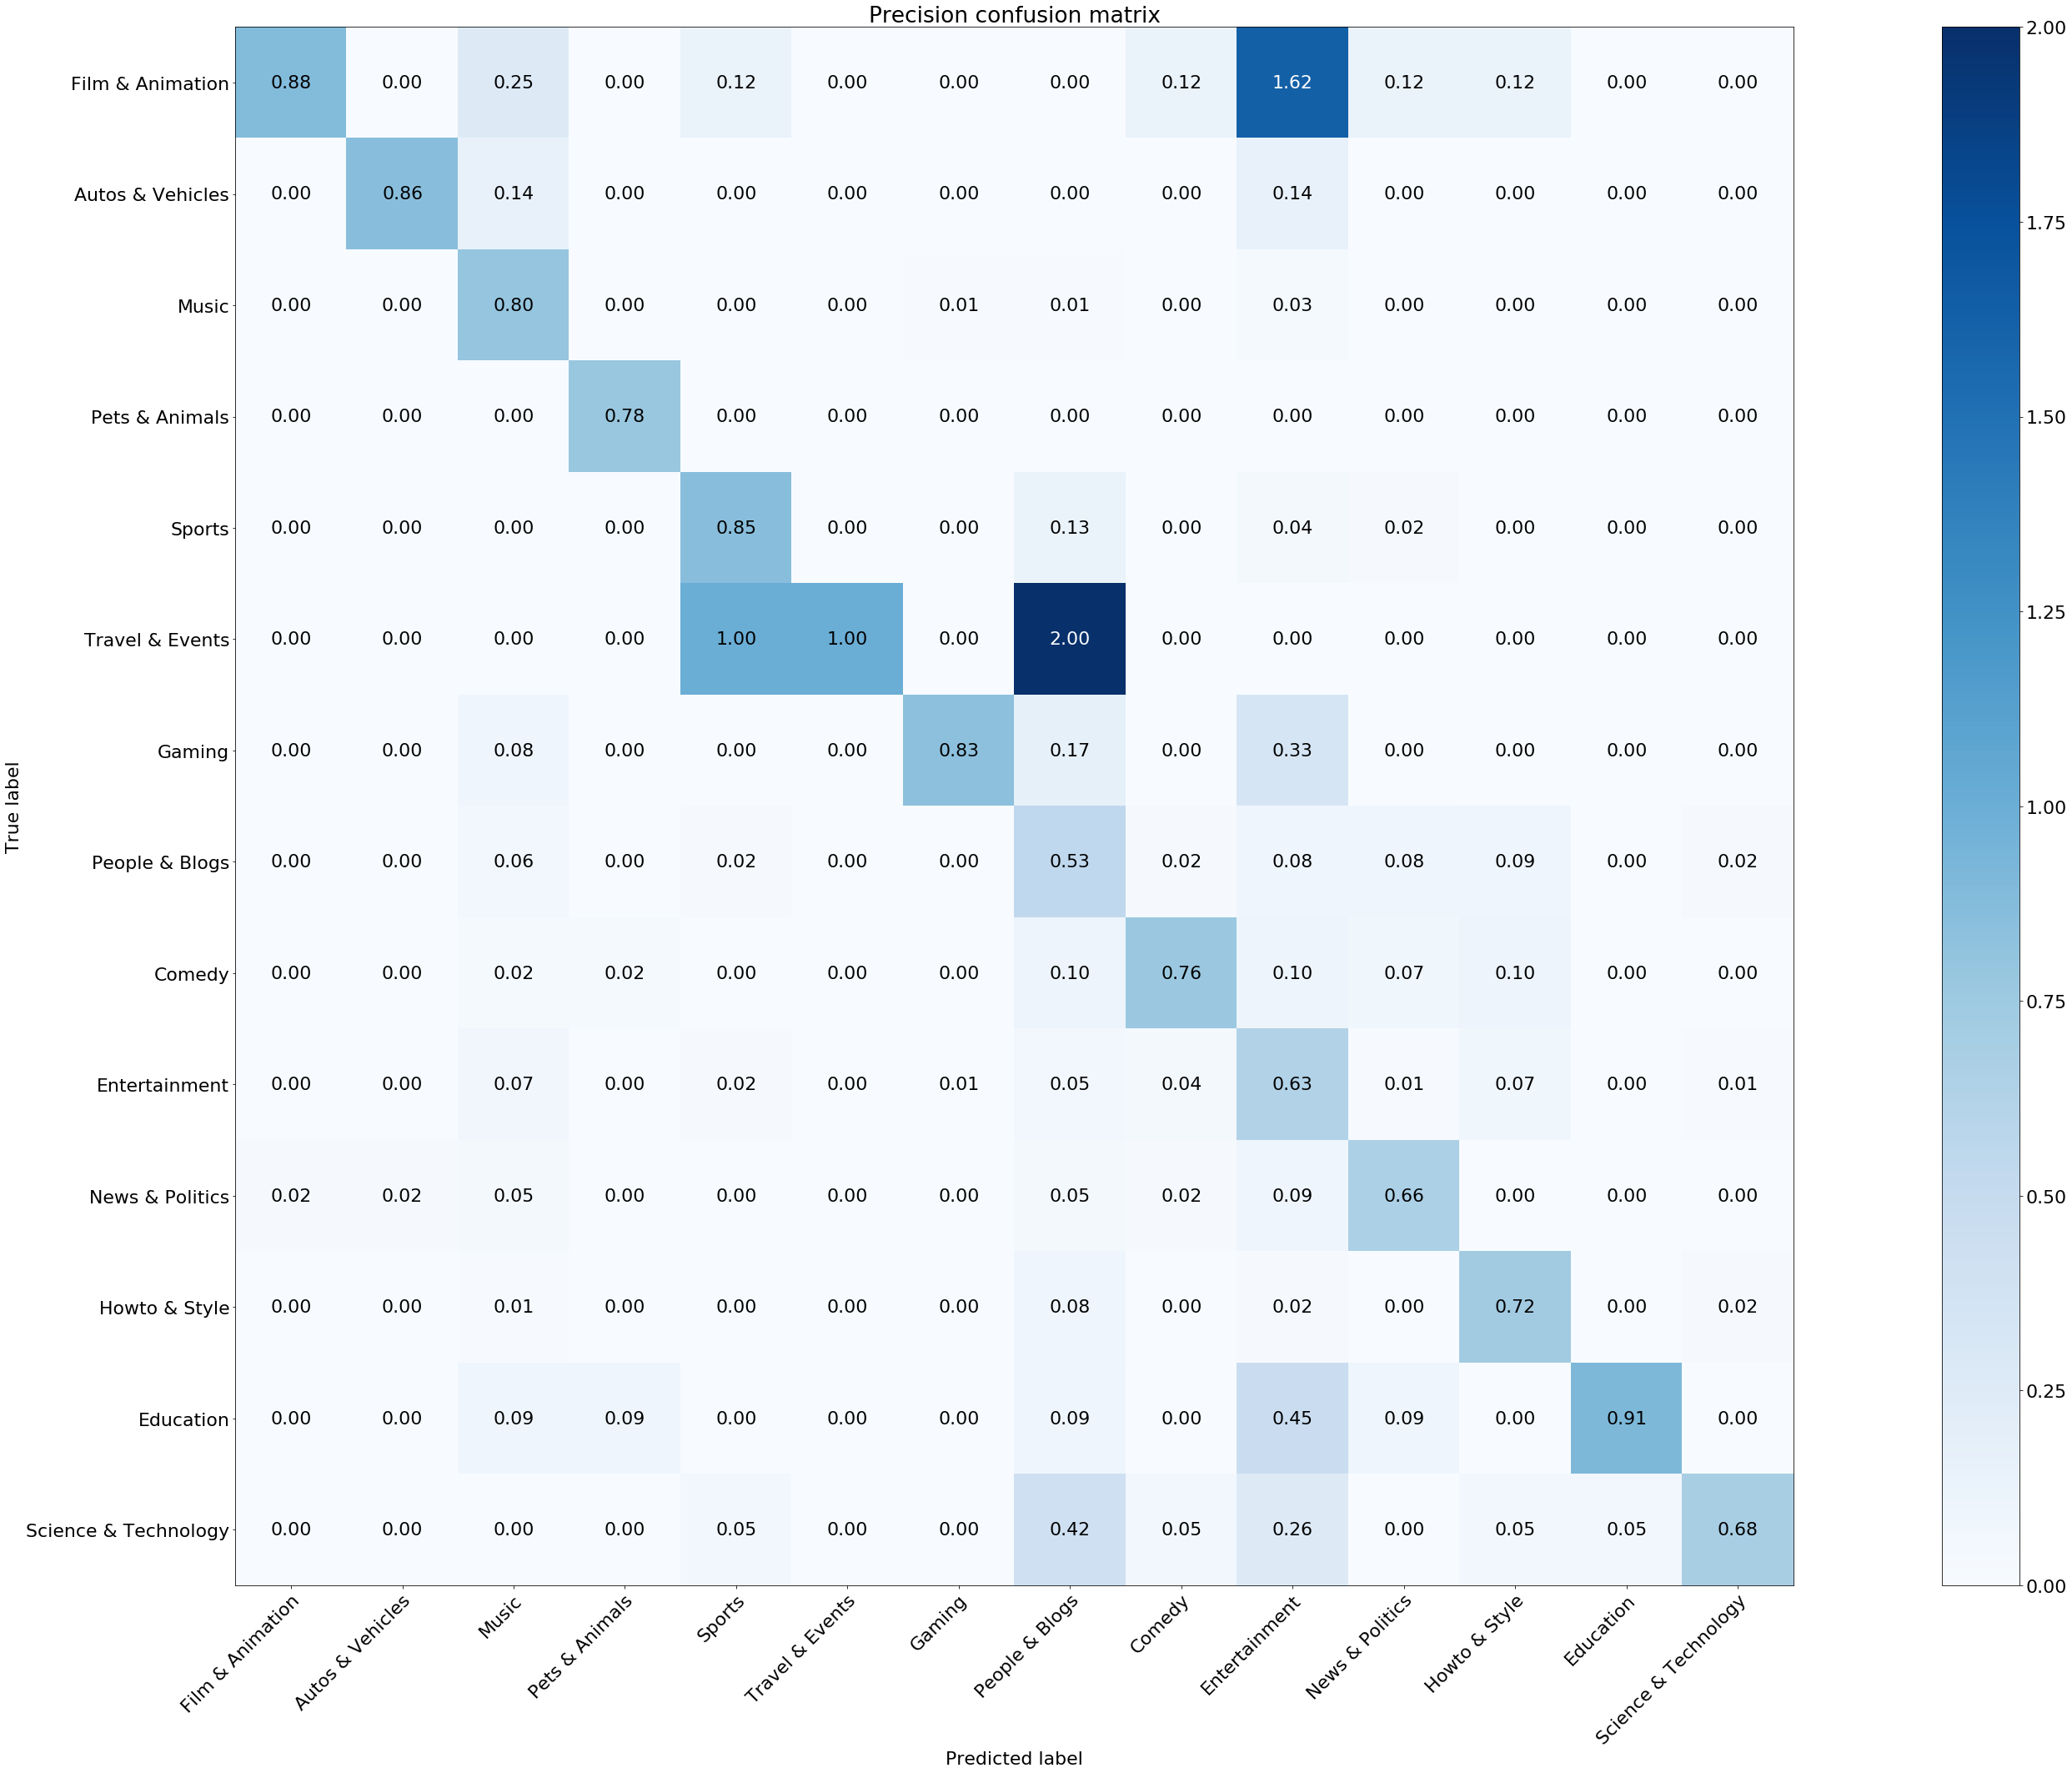

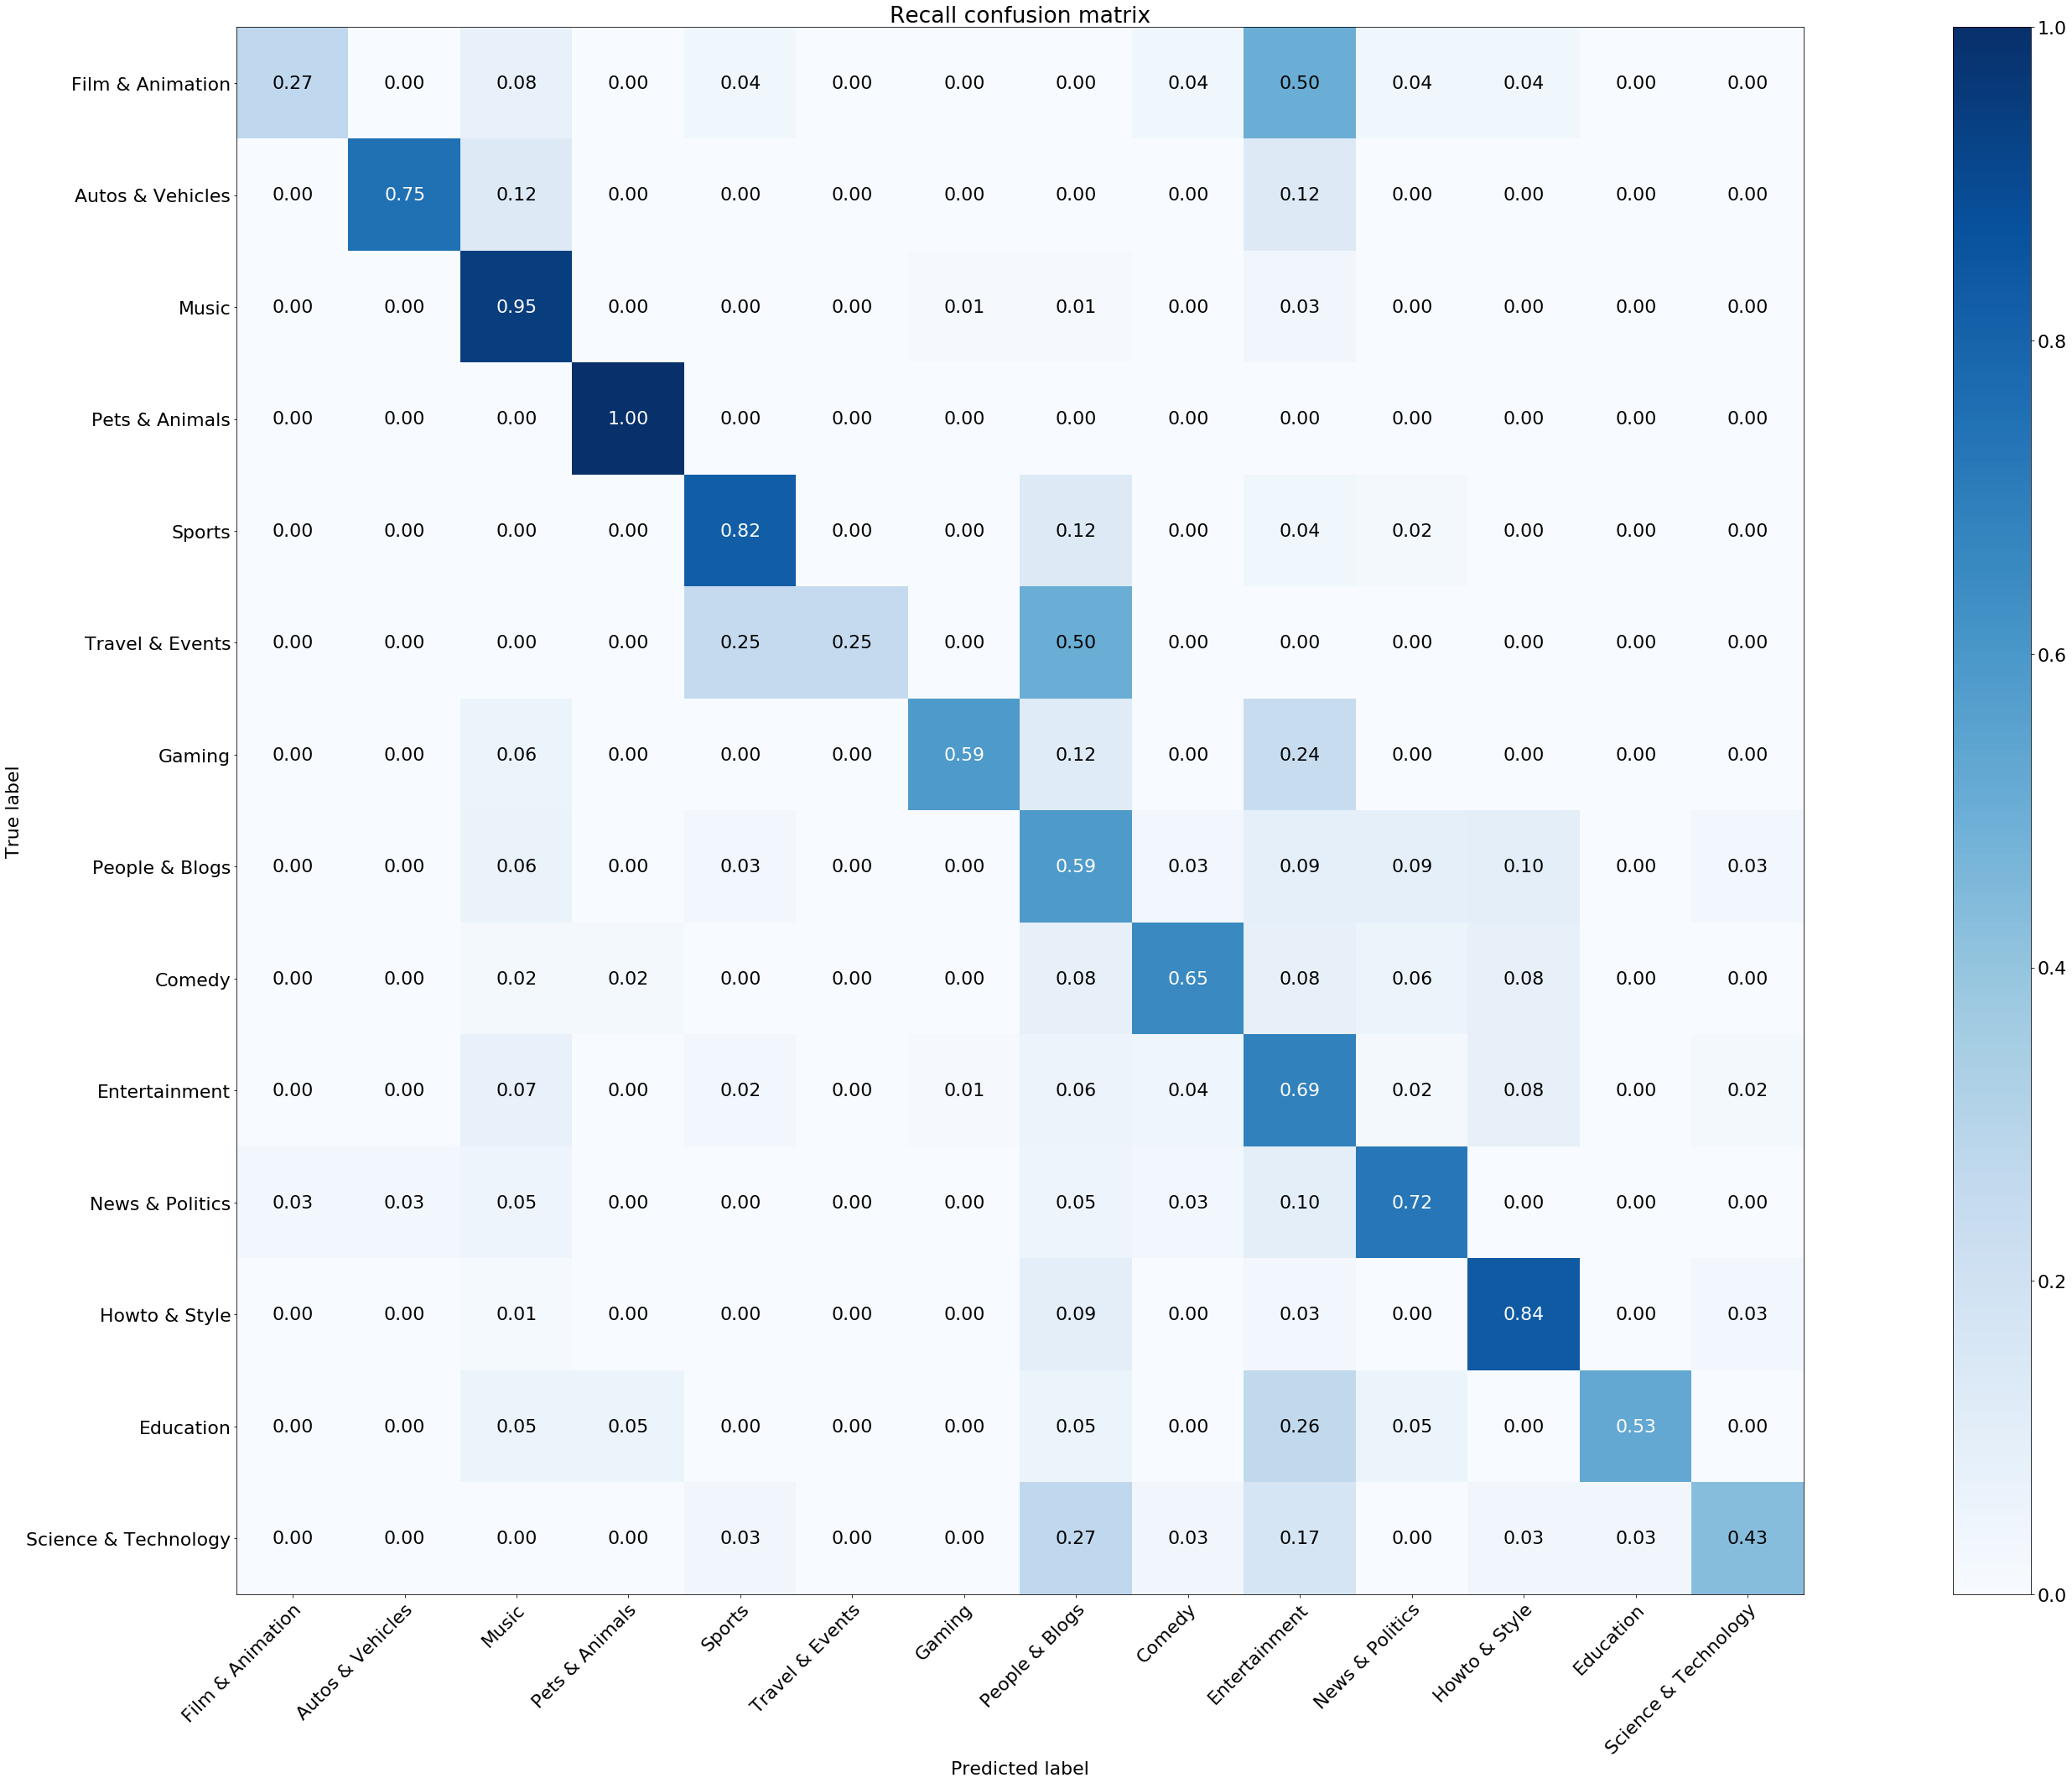

In [50]:
np.set_printoptions(precision=2)
class_names = np.array([i[1] for i in sorted(list(category_id_to_word.items()), key=lambda x: x[0])])

# Plot non-normalized confusion matrix

plot_confusion_matrix(y_test, y_pred, classes=class_names, type_of_plot="no_normalization",
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, type_of_plot="precision",
                      title='Precision confusion matrix')

plot_confusion_matrix(y_test, y_pred, classes=class_names, type_of_plot="recall",
                      title='Recall confusion matrix')


plt.show()